# Assign 2 - Deep Learning
Jonathan Menahem - 203772611 <br>
Alon Mazri - 311503841

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import imagesize
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras import layers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.layers.experimental.preprocessing as preprocessing

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading The Data

In [3]:
image_size=(256, 256)
train_directory = 'chest_xray/train'
test_directory = 'chest_xray/test'
seed = np.random.randint(50, dtype=int)

# these are all default input values from documentation
train_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=image_size,
    shuffle=True, seed=seed, validation_split=0.15, subset='training',
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=image_size, 
    shuffle=True, seed=seed, validation_split=0.15, subset='validation',
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

# these are all default input values from documentation
test_data = tf.keras.utils.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=image_size,
    shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 5232 files belonging to 2 classes.
Using 4448 files for training.
Found 5232 files belonging to 2 classes.
Using 784 files for validation.
Found 624 files belonging to 2 classes.


In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = validation_data.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = test_data.map(lambda x, y: (normalization_layer(x), y))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = normalized_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
train_labels = np.array([])

for x, y in train_data:
    train_labels = np.concatenate([train_labels, np.argmax(y.numpy(), axis = -1)])

val_labels =  np.array([])

for x, y in validation_data:
    val_labels = np.concatenate([val_labels, np.argmax(y.numpy(), axis = -1)])

test_labels =  np.array([])

for x, y in test_data:
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis = -1)])


print("Train Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Labels Shape:", test_labels.shape)

Train Labels Shape: (4448,)
Validation Labels Shape: (784,)
Test Labels Shape: (624,)


In [7]:
train_cases_count = np.unique(train_labels, return_counts=True)
val_cases_count = np.unique(val_labels, return_counts=True)
test_cases_count = np.unique(test_labels, return_counts=True)

total_cases_count = train_cases_count[1] + val_cases_count[1] + test_cases_count[1]

COUNT_NORMAL = total_cases_count[0]
COUNT_PNEUMONIA = total_cases_count[1]
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA

In [8]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.85
Weight for class 1: 0.69


## Transfer Learning
### resnet, densenet, inception, efficientnet

[Transfer Learning Tensorflow](https://www.tensorflow.org/tutorials/images/transfer_learning)

[Example using Resnet50](https://www.kaggle.com/abhishekdhule/pneumonia-detection-resnet-inception-tensorflow#Model-2-(ResNet-50))

[Example using Resnet50 #2](https://www.kaggle.com/satyaprakash13820/implementing-resnet-architecture)

### ResNet152 - Bottom Layer Training

In [9]:
from tensorflow.keras.applications import ResNet152

num_classes = 2
input_shape = (256, 256, 3)

pretrained_resnet = ResNet152(include_top=False, input_tensor=None, input_shape=input_shape, pooling=None)

#freazing the trained layers
for layers in pretrained_resnet.layers:
    layers.trainable = False

pretrained_resnet.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [10]:
last_layer = pretrained_resnet.get_layer('conv5_block3_1_relu')
last_output = last_layer.output


x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(128, activation='relu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

resnet_model = tf.keras.Model(pretrained_resnet.input, x)

METRICS = ['accuracy']

resnet_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [12]:
epochs = 20

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

callbacks = [learning_rate, early_stopping]

resnet_history = resnet_model.fit(train_ds ,validation_data=val_ds ,epochs=epochs, callbacks=callbacks, verbose=2)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 - 32s - loss: 0.4475 - accuracy: 0.7842 - val_loss: 0.2949 - val_accuracy: 0.8852 - lr: 0.0010 - 32s/epoch - 231ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 - 21s - loss: 0.2908 - accuracy: 0.8759 - val_loss: 0.2259 - val_accuracy: 0.9056 - lr: 8.5000e-04 - 21s/epoch - 150ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 - 21s - loss: 0.2269 - accuracy: 0.9087 - val_loss: 0.1999 - val_accuracy: 0.9069 - lr: 6.1413e-04 - 21s/epoch - 150ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003771495455584954.
Epoch 4/20
139/139 - 21s - loss: 0.1997 - accuracy: 0.9251 - val_loss: 0.1705 - val_accuracy: 0.9375 - lr: 3.7715e-04 - 21s/epoch - 150ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.00019687442435679256.
Epoch 5/20


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


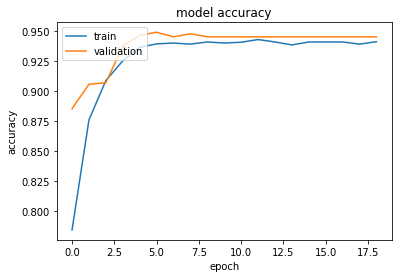

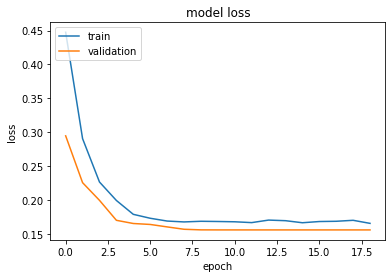

In [13]:
# list all data in history
print(resnet_history.history.keys())
# summarize history for accuracy
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
loss, accuracy = resnet_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 3s 123ms/step - loss: 0.6263 - accuracy: 0.7292
Test loss: 0.6263019442558289
Test accuracy: 0.7291666865348816


In [15]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(resnet_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


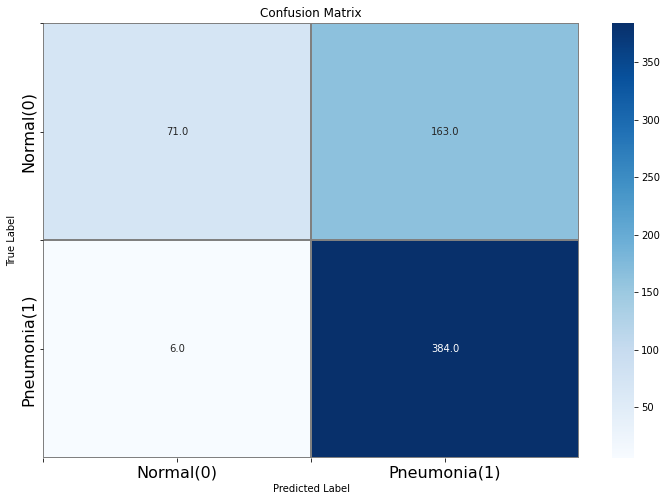

In [16]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.92      0.30      0.46       234
         1.0       0.70      0.98      0.82       390

    accuracy                           0.73       624
   macro avg       0.81      0.64      0.64       624
weighted avg       0.78      0.73      0.68       624



### DenseNet - Bottom Layer Training

In [18]:
from tensorflow.keras.applications import DenseNet121

num_classes = 2
input_shape = (256, 256, 3)

pretrained_densenet = DenseNet121(include_top=False, input_tensor=None, input_shape=input_shape, pooling=None)

#freazing the trained layers
for layers in pretrained_densenet.layers:
    layers.trainable = False

pretrained_densenet.summary()

29097984/29084464 [==============================] - 3s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [28]:
last_layer = pretrained_densenet.get_layer('conv5_block15_1_relu')
last_output = last_layer.output


x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(128, activation='relu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

densenet_model = tf.keras.Model(pretrained_densenet.input, x)

METRICS = ['accuracy']

densenet_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

densenet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [29]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [30]:
epochs = 20

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

callbacks = [learning_rate, early_stopping]

densenet_history = densenet_model.fit(train_ds ,validation_data=val_ds ,epochs=epochs, callbacks=callbacks, verbose=2)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 - 27s - loss: 0.1711 - accuracy: 0.9400 - val_loss: 0.0752 - val_accuracy: 0.9745 - lr: 0.0010 - 27s/epoch - 198ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 - 21s - loss: 0.0500 - accuracy: 0.9858 - val_loss: 0.0596 - val_accuracy: 0.9758 - lr: 8.5000e-04 - 21s/epoch - 150ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 - 24s - loss: 0.0286 - accuracy: 0.9928 - val_loss: 0.0556 - val_accuracy: 0.9770 - lr: 6.1413e-04 - 24s/epoch - 172ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003771495455584954.
Epoch 4/20
139/139 - 23s - loss: 0.0194 - accuracy: 0.9969 - val_loss: 0.0545 - val_accuracy: 0.9783 - lr: 3.7715e-04 - 23s/epoch - 162ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.00019687442435679256.
Epoch 5/20


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


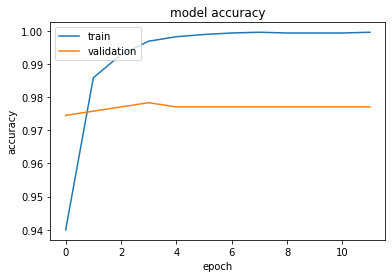

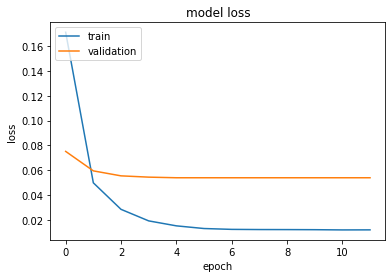

In [31]:
# list all data in history
print(densenet_history.history.keys())
# summarize history for accuracy
plt.plot(densenet_history.history['accuracy'])
plt.plot(densenet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(densenet_history.history['loss'])
plt.plot(densenet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
loss, accuracy = densenet_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 1s 60ms/step - loss: 0.7572 - accuracy: 0.7837
Test loss: 0.7571943402290344
Test accuracy: 0.7836538553237915


In [33]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(densenet_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


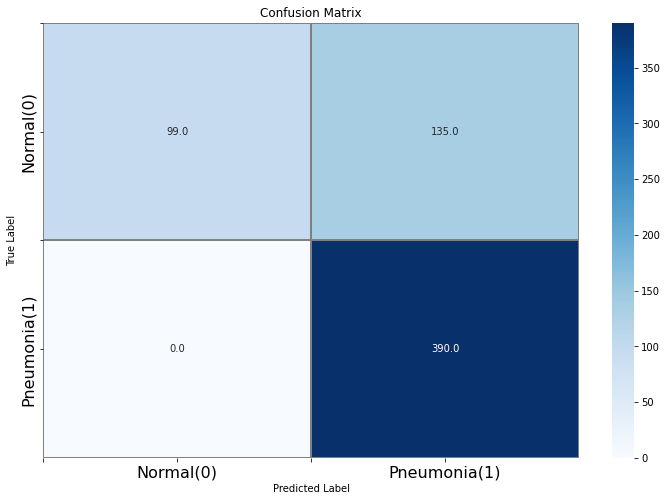

In [34]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [35]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       1.00      0.42      0.59       234
         1.0       0.74      1.00      0.85       390

    accuracy                           0.78       624
   macro avg       0.87      0.71      0.72       624
weighted avg       0.84      0.78      0.76       624



###  Inception - Bottom Layer Training

In [9]:
from tensorflow.keras.applications import InceptionV3

num_classes = 2
input_shape = (256, 256, 3)

pretrained_inception = InceptionV3(include_top=False, input_tensor=None, input_shape=input_shape, pooling=None)

#freazing the trained layers
for layers in pretrained_inception.layers:
    layers.trainable = False

last_layer_name = 'conv2d_86'
last_index = 0
idx = 0
for layer in pretrained_inception.layers:
    if layer.name == last_layer_name:
        last_index = idx
        print('end layer number', last_index)
    idx += 1

pretrained_inception.summary()

end layer number 283
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                 

In [10]:
last_layer = pretrained_inception.get_layer(index=last_index)
last_output = last_layer.output


x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(128, activation='relu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

inception_model = tf.keras.Model(pretrained_inception.input, x)

METRICS = ['accuracy']

inception_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [12]:
epochs = 20

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

callbacks = [learning_rate, early_stopping]

inception_history = inception_model.fit(train_ds ,validation_data=val_ds ,epochs=epochs, callbacks=callbacks, verbose=2)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 - 15s - loss: 0.2310 - accuracy: 0.9272 - val_loss: 0.0820 - val_accuracy: 0.9643 - lr: 0.0010 - 15s/epoch - 108ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 - 7s - loss: 0.0768 - accuracy: 0.9705 - val_loss: 0.0669 - val_accuracy: 0.9758 - lr: 8.5000e-04 - 7s/epoch - 47ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 - 7s - loss: 0.0550 - accuracy: 0.9820 - val_loss: 0.0727 - val_accuracy: 0.9643 - lr: 6.1413e-04 - 7s/epoch - 48ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003771495455584954.
Epoch 4/20
139/139 - 6s - loss: 0.0440 - accuracy: 0.9858 - val_loss: 0.0713 - val_accuracy: 0.9681 - lr: 3.7715e-04 - 6s/epoch - 46ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.00019687442435679256.
Epoch 5/20
139/139 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


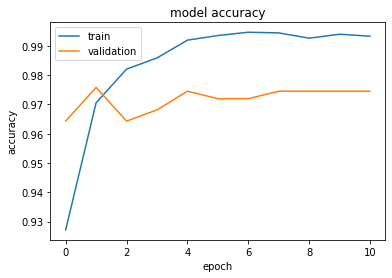

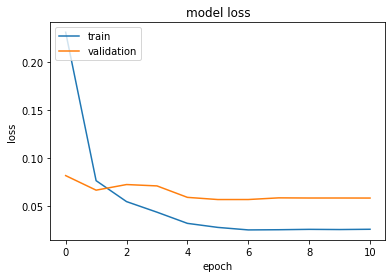

In [13]:
# list all data in history
print(inception_history.history.keys())
# summarize history for accuracy
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
loss, accuracy = inception_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 1s 47ms/step - loss: 0.7936 - accuracy: 0.7821
Test loss: 0.7936044931411743
Test accuracy: 0.7820512652397156


In [15]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(inception_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


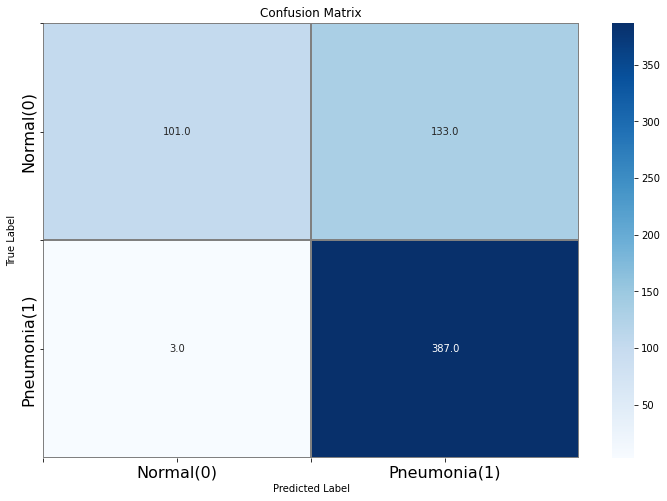

In [16]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.97      0.43      0.60       234
         1.0       0.74      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.71      0.72       624
weighted avg       0.83      0.78      0.76       624



###  Inception - Middle Layer Training

In [18]:
from tensorflow.keras.applications import InceptionV3

num_classes = 2
input_shape = (256, 256, 3)

pretrained_inception_mid = InceptionV3(include_top=False, input_tensor=None, input_shape=input_shape, pooling=None)

pretrained_inception_mid.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [19]:
#freazing the trained layers
start_layer = 'conv2d_44'
end_layer = 'average_pooling2d_4'
last_layer_name = 'conv2d_86'
start_index = 0
end_index = 0
last_index = 0
idx = 0
for layer in pretrained_inception_mid.layers:
    if layer.name == start_layer:
        start_index = idx
        print('start layer number', start_index)
    if layer.name == end_layer:
        end_index = idx
        print('end layer number', end_index)
    if layer.name == last_layer_name:
        last_index = idx
        print('end layer number', last_index)
    idx += 1


In [20]:
#freazing the trained layers

start_layer = 'conv2d_44'
end_layer = 'average_pooling2d_4'

for layer in pretrained_inception_mid.layers[:start_index]:
    layer.trainable=False
for layer in pretrained_inception_mid.layers[start_index:end_index]:
    layer.trainable=True
for layer in pretrained_inception_mid.layers[end_index:]:
    layer.trainable=False

In [21]:
last_layer = pretrained_inception_mid.get_layer(index=last_index)
last_output = last_layer.output


x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(128, activation='relu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

inception_mid_model = tf.keras.Model(pretrained_inception_mid.input, x)

METRICS = ['accuracy']

inception_mid_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

inception_mid_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               25165952  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 25,166,210
Trainable params: 25,166,210
Non-trainable params: 0
_________________________________________________________________


In [22]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [23]:
epochs = 20

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

callbacks = [learning_rate, early_stopping]

inception_mid_history = inception_mid_model.fit(train_ds ,validation_data=val_ds ,epochs=epochs, callbacks=callbacks, verbose=2)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 - 2s - loss: 3.7175 - accuracy: 0.8201 - val_loss: 0.3144 - val_accuracy: 0.8839 - lr: 0.0010 - 2s/epoch - 12ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 - 1s - loss: 0.3081 - accuracy: 0.8781 - val_loss: 0.2830 - val_accuracy: 0.9439 - lr: 8.5000e-04 - 1s/epoch - 9ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 - 1s - loss: 0.2908 - accuracy: 0.8838 - val_loss: 0.2544 - val_accuracy: 0.9324 - lr: 6.1413e-04 - 1s/epoch - 9ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003771495455584954.
Epoch 4/20
139/139 - 1s - loss: 0.2684 - accuracy: 0.9218 - val_loss: 0.3304 - val_accuracy: 0.8839 - lr: 3.7715e-04 - 1s/epoch - 8ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.00019687442435679256.
Epoch 5/20
139/139 - 1s - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


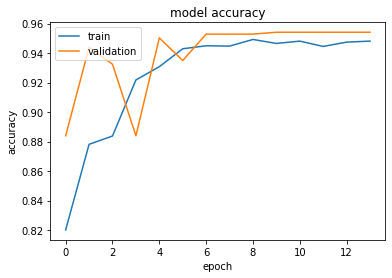

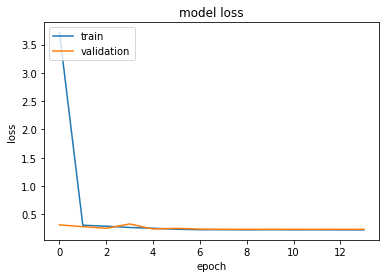

In [24]:
# list all data in history
print(inception_mid_history.history.keys())
# summarize history for accuracy
plt.plot(inception_mid_history.history['accuracy'])
plt.plot(inception_mid_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(inception_mid_history.history['loss'])
plt.plot(inception_mid_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
loss, accuracy = inception_mid_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 0s 5ms/step - loss: 0.7444 - accuracy: 0.7500
Test loss: 0.7444496750831604
Test accuracy: 0.75


In [26]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(inception_mid_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


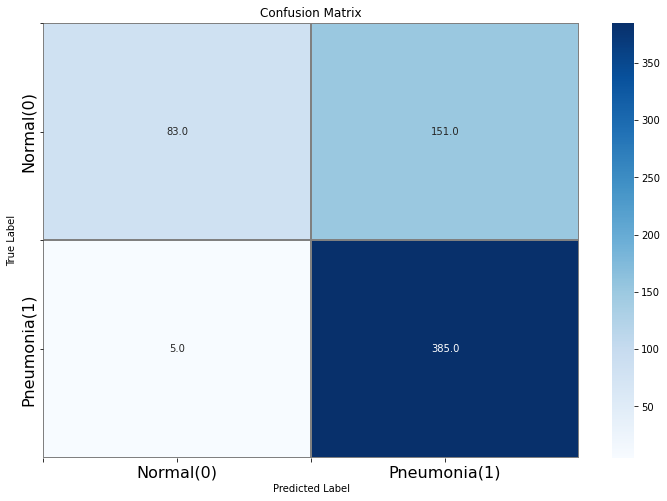

In [27]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.94      0.35      0.52       234
         1.0       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.83      0.67      0.67       624
weighted avg       0.80      0.75      0.71       624

